In [1]:
# Load swiss temperature data

import pandas as pd
import glob

path = "data/swiss"
filenames = glob.glob(path + "/*.txt")
dfs = []
N = len(filenames)
for filename in filenames:
    with open(filename, encoding="Windows-1252") as f:
        content = f.readlines()
        station = content[5].split(None, 1)[1][:-1]
        altitude = float(content[6].split()[3])
        latitude = int(content[7].split()[1][:-1]) + float(content[7].split()[2][:-1]) / 60
        longitude = int(content[7].split()[5][:-1]) + float(content[7].split()[6][:-1]) / 60
    df = pd.read_table(
        filename,
        encoding="Windows-1252",
        delim_whitespace=True,
        skiprows=27,
    )
    df["Station"] = station
    df["Altitude"] = altitude
    df["Latitude"] = latitude
    df["Longitude"] = longitude
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all.head()


,Year,Month,Temperature,Precipitation,Station,Altitude,Latitude,Longitude
0,1864,1,-4.5,40.8,Altdorf,438.0,46.886667,8.621667
1,1864,2,-0.4,38.0,Altdorf,438.0,46.886667,8.621667
2,1864,3,5.4,31.6,Altdorf,438.0,46.886667,8.621667
3,1864,4,7.2,155.1,Altdorf,438.0,46.886667,8.621667
4,1864,5,12.6,103.9,Altdorf,438.0,46.886667,8.621667


C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_28932\2493413670.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_1965_1989_january = data_1965_1989[df_all["Month"] == 1].groupby("Station")
C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_28932\2493413670.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_1965_1989_july = data_1965_1989[df_all["Month"] == 7].groupby("Station")


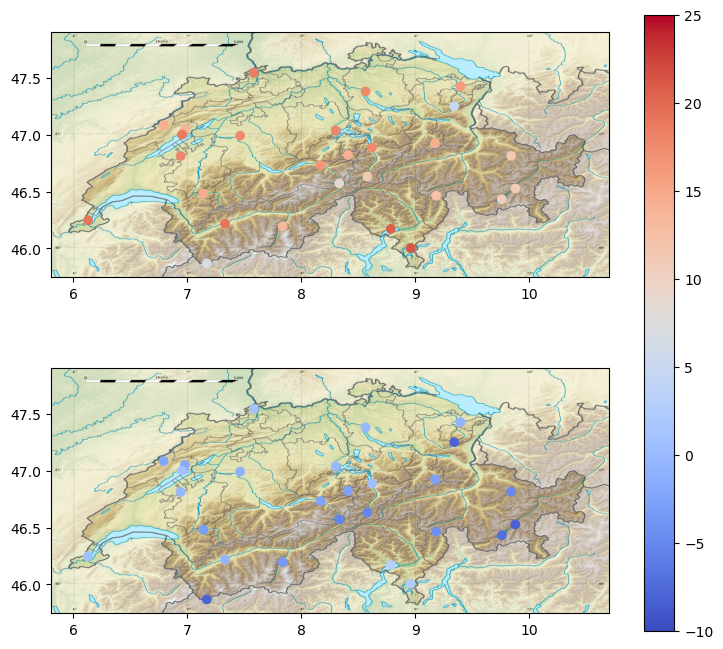

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

data_1965_1989 = df_all[(df_all["Year"] >= 1965) & (df_all["Year"] < 1990)]
data_1965_1989_january = data_1965_1989[df_all["Month"] == 1].groupby("Station")
data_1965_1989_july = data_1965_1989[df_all["Month"] == 7].groupby("Station")

img = plt.imread("data/swiss/Switzerland_relief_location_map.jpg")
plt.figure(figsize=(9, 8))
ax1 = plt.subplot(2, 1, 1)
ax1.imshow(img, zorder=0, extent=[5.8, 10.7, 45.75, 47.9])
ax1.scatter(data_1965_1989_july.mean()["Longitude"], data_1965_1989_july.mean()["Latitude"], c=data_1965_1989_july.mean()["Temperature"], cmap="coolwarm", vmin=-10, vmax=25)

ax2 = plt.subplot(2, 1, 2)
ax2.imshow(img, zorder=0, extent=[5.8, 10.7, 45.75, 47.9])
im = ax2.scatter(data_1965_1989_january.mean()["Longitude"], data_1965_1989_january.mean()["Latitude"], c=data_1965_1989_january.mean()["Temperature"], cmap="coolwarm", vmin=-10, vmax=25)
plt.colorbar(im, ax=[ax1, ax2])
plt.show()


(CVXPY) Nov 29 10:35:50 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
0
(27, 25)
1
(27, 25)
2
(27, 25)
3
(27, 25)
4
(27, 25)
5
(27, 25)
6
(27, 25)
7
(27, 25)
8
(27, 25)
9
(27, 25)
10
(27, 25)
11
(27, 25)
12
(27, 25)
13
(27, 25)
14
(27, 25)
15
(27, 25)
16
(27, 25)
17
(27, 25)
18
(27, 25)
19
(27, 25)
0
(27, 25)
1
(27, 25)
2
(27, 25)
3
(27, 25)
4
(27, 25)
5
(27, 25)
6
(27, 25)
7
(27, 25)
8
(27, 25)
9
(27, 25)
10
(27, 25)
11
(27, 25)
12
(27, 25)
13
(27, 25)
14
(27, 25)
15
(27, 25)
16
(27, 25)
17
(27, 25)
18
(27, 25)
19
(27, 25)
[[-1.03526143e-01 -7.88005214e-11 -1.61406594e-01  2.20873416e-01
   1.06709565e-09 -1.54899985e-09 -4.47392159e-09 -8.55097178e-11
  -1.55569373e-09 -1.54525757e-09 -2.69626723e-01 -4.96848770e-09
  -1.08387129e-09 -1.53703527e-09  8.60772937e-10  5.15644648e-09
   8.47748732e-02  1.76580967e-01 -1.91995815e-01  1.46817072e-01
  -2.53326800e-09 -1.35120316e-

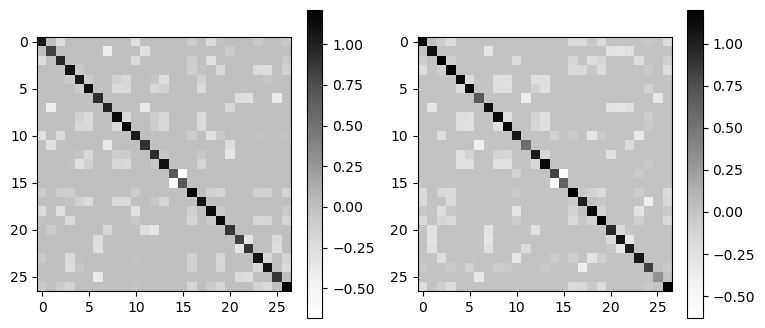

In [3]:
import cvxpy as cp
import numpy as np

def topo_infer_smooth(data, N, alpha, beta, iter, tr=N):
    M = data.shape[1] if data.ndim == 2 else 1
    if M == 1:
        data = data.reshape(-1, 1)
    y = cp.Variable((N, M))
    y_0 = data
    Lap = cp.Variable((N, N), PSD=True)

    for cnt in range(iter):
        print(cnt)
        constraints = [Lap @ np.ones((N,)) == np.zeros((N,)), Lap - cp.diag(cp.diag(Lap)) <= 0, cp.trace(Lap) == tr]
        print(y_0.shape)
        objective = cp.Minimize(alpha * cp.trace(cp.quad_form(y_0, Lap)) + beta * cp.norm(Lap, "fro") ** 2)
        prob = cp.Problem(objective, constraints)
        prob.solve()
        Lap_0 = Lap.value
        Lap_0 = Lap_0 - np.eye(N) * np.min(np.linalg.eigvals(Lap_0))
        objective2 = cp.Minimize(cp.norm(y - data, "fro") ** 2 + alpha * cp.sum([cp.quad_form(y[:, i], Lap_0) for i in range(M)]))
        prob2 = cp.Problem(objective2)
        prob2.solve()
        y_0 = y.value
    
    return Lap_0

t_january = np.array(data_1965_1989_january["Temperature"].apply(lambda x: np.array(x.values.tolist())).to_list())
t_july = np.array(data_1965_1989_july["Temperature"].apply(lambda x: np.array(x.values.tolist())).to_list())

alpha = 0.01
beta = 0.5
Lap_0_january = topo_infer_smooth(t_january, N, alpha, beta, 20)
Lap_0_july = topo_infer_smooth(t_july, N, alpha, beta, 20)
print(Lap_0_january - Lap_0_july)

plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.imshow(Lap_0_january, cmap='Greys', interpolation='nearest')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(Lap_0_july, cmap='Greys', interpolation='nearest')
plt.colorbar()
plt.show()


C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_28932\3910171463.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  longitudes = [df_all[df_all.eq(station_name).any(1)]["Longitude"].values[0] for station_name in stations]
C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_28932\3910171463.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  latitudes = [df_all[df_all.eq(station_name).any(1)]["Latitude"].values[0] for station_name in stations]
C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_28932\3910171463.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  altitudes = np.array([df_all[df_all.eq(station_name).any(1)]["Altitude"].values[0] for station_name in stations])


0
(27, 1)
1
(27, 1)
2
(27, 1)
3
(27, 1)
4
(27, 1)
5
(27, 1)
6
(27, 1)
7
(27, 1)
8
(27, 1)
9
(27, 1)
10
(27, 1)
11
(27, 1)
12
(27, 1)
13
(27, 1)
14
(27, 1)
15
(27, 1)
16
(27, 1)
17
(27, 1)
18
(27, 1)
19
(27, 1)


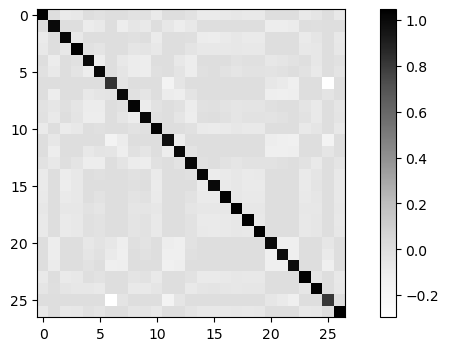

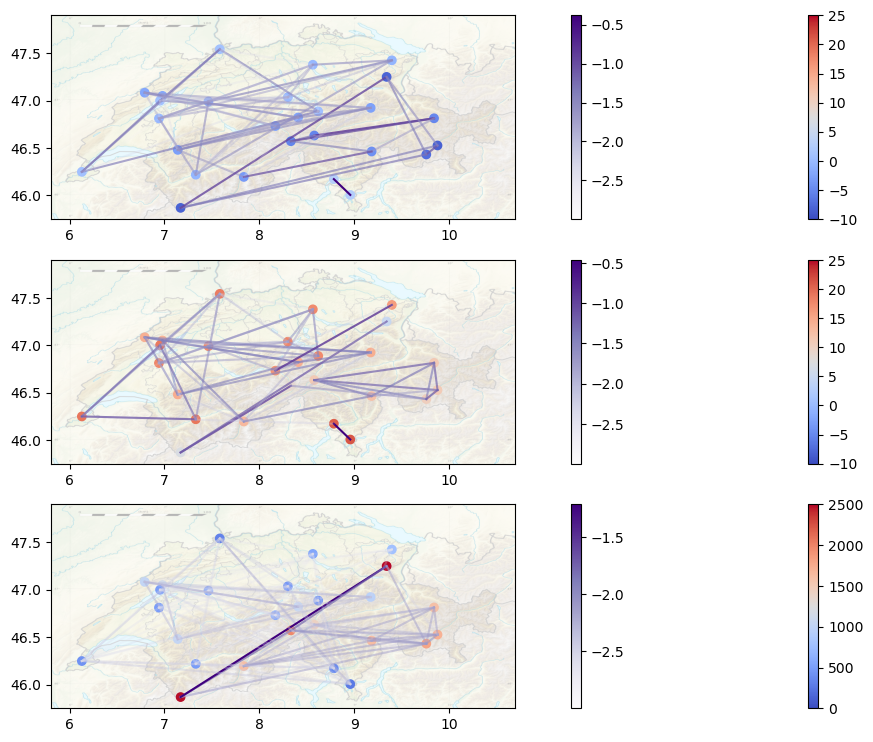

In [4]:
stations = data_1965_1989_january.mean()["Temperature"].keys()
longitudes = [df_all[df_all.eq(station_name).any(1)]["Longitude"].values[0] for station_name in stations]
latitudes = [df_all[df_all.eq(station_name).any(1)]["Latitude"].values[0] for station_name in stations]
altitudes = np.array([df_all[df_all.eq(station_name).any(1)]["Altitude"].values[0] for station_name in stations])

Lap_0_altitude = topo_infer_smooth(altitudes / 200, N, 0.01, 0.3, 20)
plt.figure(figsize=(9, 4))
plt.imshow(Lap_0_altitude, cmap='Greys', interpolation='nearest')
plt.colorbar()
plt.show()

def plot_graph(ax, data, Lap, N, th, img, vmin=-10, vmax=25):
    ax.imshow(img, zorder=0, extent=[5.8, 10.7, 45.75, 47.9], alpha=0.3)
    z = ax.scatter(longitudes, latitudes, c=data, cmap="coolwarm", vmin=vmin, vmax=vmax)
    plt.colorbar(z, ax=ax)

    color_norm = mpl.colors.Normalize(vmin=np.log(th), vmax=np.log(np.max(-Lap)))
    cmap = cm.Purples
    color_map = cm.ScalarMappable(norm=color_norm, cmap=cmap)
    for i in range(N):
        for j in range(i+1, N):
            if Lap[i, j] < -th:
                ax.plot([longitudes[i], longitudes[j]], [latitudes[i], latitudes[j]], c=color_map.to_rgba(np.log(-Lap[i, j])), alpha=color_norm(np.log(-Lap[i, j])))
    plt.colorbar(color_map)

plt.figure(figsize=(18, 9))
ax1 = plt.subplot(3, 1, 1)
plot_graph(ax1, data_1965_1989_january.mean()["Temperature"], Lap_0_january, N, 0.05, img)

ax2 = plt.subplot(3, 1, 2)
plot_graph(ax2, data_1965_1989_july.mean()["Temperature"], Lap_0_july, N, 0.05, img)

ax3 = plt.subplot(3, 1, 3)
plot_graph(ax3, altitudes, Lap_0_altitude, N, 0.05, img, vmin=0, vmax=2500)

plt.show()

C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_28932\1497127798.py:9: RuntimeWarning: divide by zero encountered in divide
  G = nx.from_numpy_matrix(1 / A)


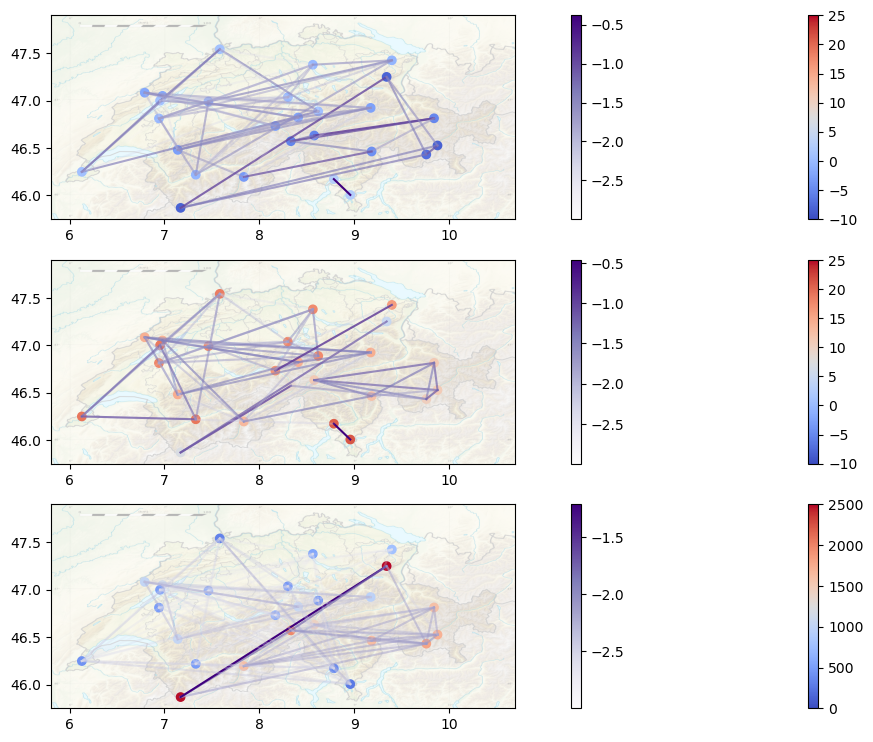

In [5]:
import networkx as nx

def graph_sparsify(Lap):
    N = Lap.shape[0]
    Lap_0 = Lap.copy()
    A = -Lap_0
    np.fill_diagonal(A, 0)
    A[A < 1e-10] = 0
    G = nx.from_numpy_matrix(1 / A)
    for i in range(N):
        for j in range(i+1, N):
            d = nx.shortest_path_length(G, i, j, weight="weight")
            p = - Lap_0[i, j] * d
            x = np.random.rand()
            if x > p or A[i, j] < 1e-10:
                Lap_0[i, j] = 0
                Lap_0[j, i] = 0
    return Lap_0

Lap_0_altitude_sparsified = graph_sparsify(Lap_0_altitude)
Lap_0_january_sparsified = graph_sparsify(Lap_0_january)
Lap_0_july_sparsified = graph_sparsify(Lap_0_july)

plt.figure(figsize=(18, 9))
ax1 = plt.subplot(3, 1, 1)
plot_graph(ax1, data_1965_1989_january.mean()["Temperature"], Lap_0_january_sparsified, N, 0.05, img)

ax2 = plt.subplot(3, 1, 2)
plot_graph(ax2, data_1965_1989_july.mean()["Temperature"], Lap_0_july_sparsified, N, 0.05, img)

ax3 = plt.subplot(3, 1, 3)
plot_graph(ax3, altitudes, Lap_0_altitude_sparsified, N, 0.05, img, vmin=0, vmax=2500)

plt.show()


                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) Nov 29 11:57:02 PM: Your problem has 8019 variables, 0 constraints, and 0 parameters.
(CVXPY) Nov 29 11:57:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 29 11:57:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 29 11:57:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 29 11:57:02 PM: Compiling problem (target solver=ECOS).
(CVXPY) Nov 29 11:57:02 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

e:\anaconda3\envs\py3.9\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


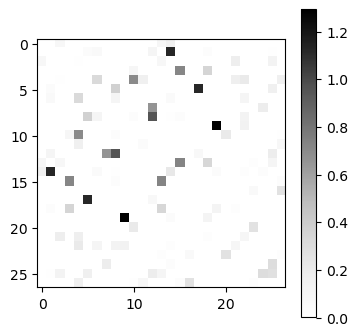

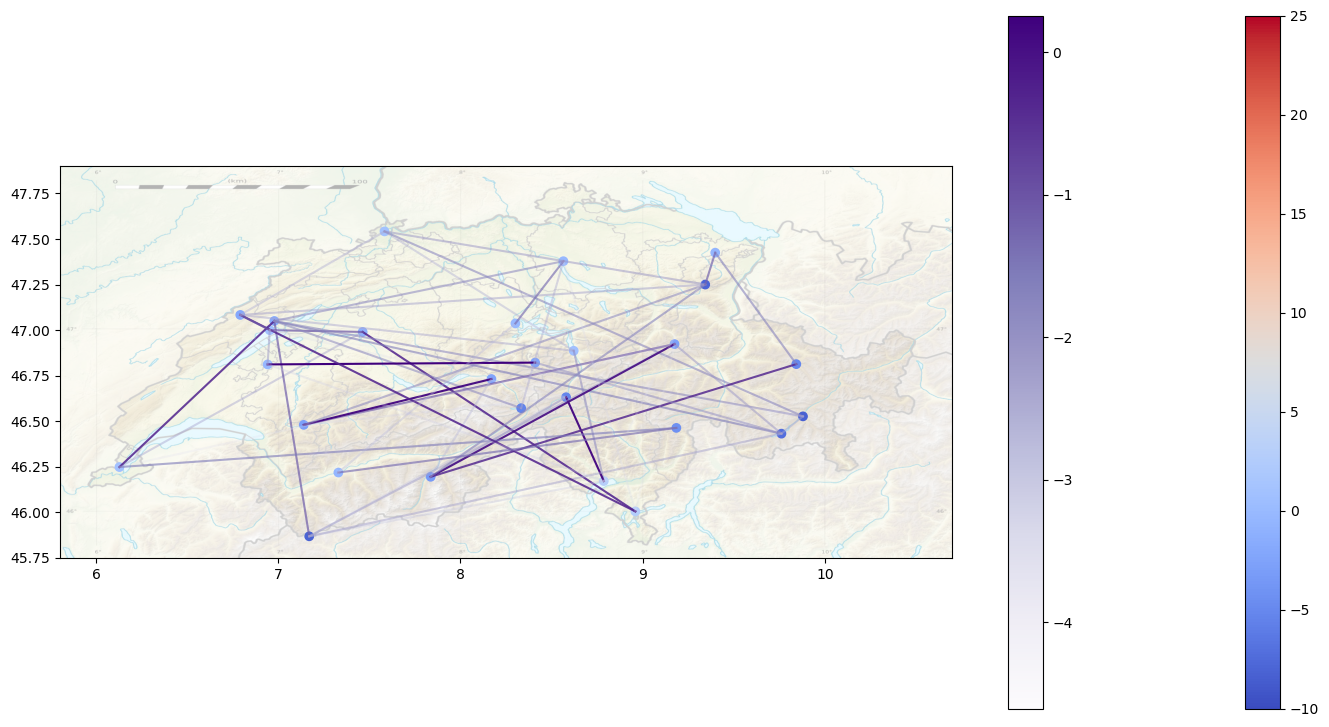

In [87]:
data_1965_1989_time = data_1965_1989.groupby("Station")

data_1965_1989_temp = np.array(
    data_1965_1989_time["Temperature"]
    .apply(lambda x: np.array(x.values.tolist()))
    .values.tolist()
).reshape(
    len(stations), -1, 12
)  # number of stations (27) x number of years (25) x months (12)

def topo_infer_time(data, N, alpha, beta, k=12):
    R_list = [cp.Variable((N, N), symmetric=True) for _ in range(k-1)]
    constraints = []
    # constraints = [R >= 0 for R in R_list]  + [cp.sum(R) == N for R in R_list]
    objective = cp.Minimize(cp.sum_squares(data[:, :, -1] - cp.sum([R_list[i] @ data[:, :, i] for i in range(k-1)], axis=2)) + alpha * cp.sum([cp.norm(R, 1) for R in R_list]))
    prob = cp.Problem(objective, constraints)
    prob.solve(verbose=True)
    R_list_0 = [R.value for R in R_list]

    A = cp.Variable((N, N), symmetric=True)
    constraints = [A >= 0, cp.sum(A) == N]
    objective = cp.Minimize(cp.sum_squares(R_list_0[-1] - A) + alpha * cp.sum(A) + beta * cp.sum([cp.sum_squares(R - A) for R in R_list_0[:-1]]))
    prob = cp.Problem(objective, constraints)
    prob.solve(verbose=True)

    return np.array([R.value for R in R_list]), A.value

R_list, A = topo_infer_time(data_1965_1989_temp, N, 1, 0.2)
print(A)

plt.figure(figsize=(4, 4))
plt.imshow(A, cmap='Greys', interpolation='nearest')
plt.colorbar()
plt.show()

plt.figure(figsize=(18, 9))
ax1 = plt.subplot(1, 1, 1)
plot_graph(ax1, data_1965_1989_january.mean()["Temperature"], -A, N, 0.01, img)

plt.show()


[[[ 8.79570261e-01 -5.21783290e-01 -3.84748224e-11 ... -8.75338488e-01
    7.79408126e-11 -3.53022786e-11]
  [-5.21783290e-01  7.62484123e-01 -8.80425424e-10 ... -2.67672828e-10
    2.63751649e-10 -8.06158403e-10]
  [-3.84748224e-11 -8.80425424e-10 -3.21796029e-10 ... -3.28179892e-11
   -2.23193220e+00 -1.11664318e+00]
  ...
  [-8.75338488e-01 -2.67672828e-10 -3.28179892e-11 ...  1.21474706e-09
    1.86250839e+00 -1.73820524e+00]
  [ 7.79408126e-11  2.63751649e-10 -2.23193220e+00 ...  1.86250839e+00
   -3.44039512e-10  3.19202057e-11]
  [-3.53022786e-11 -8.06158403e-10 -1.11664318e+00 ... -1.73820524e+00
    3.19202057e-11 -1.42599084e-09]]

 [[-1.88281578e+00 -9.42110635e-01  1.09806837e-10 ...  1.19852957e+00
    6.37145282e-11  1.08276446e-09]
  [-9.42110635e-01  2.30459060e+00  3.60004274e-10 ...  4.84098346e-01
    3.41660520e-01  5.10440929e-11]
  [ 1.09806837e-10  3.60004274e-10  2.11293012e+00 ... -2.74721486e+00
   -4.73941704e-10 -1.52788004e-10]
  ...
  [ 1.19852957e+00  4.8

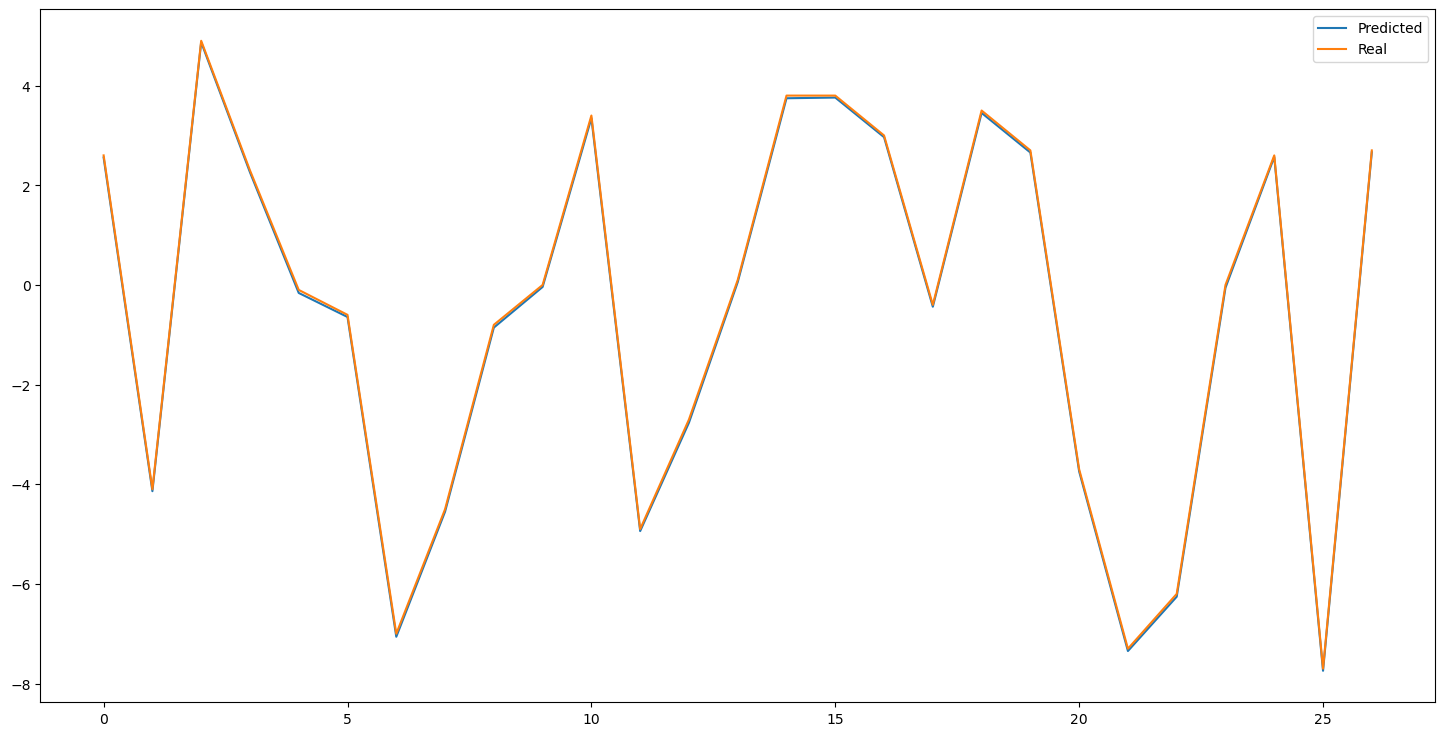

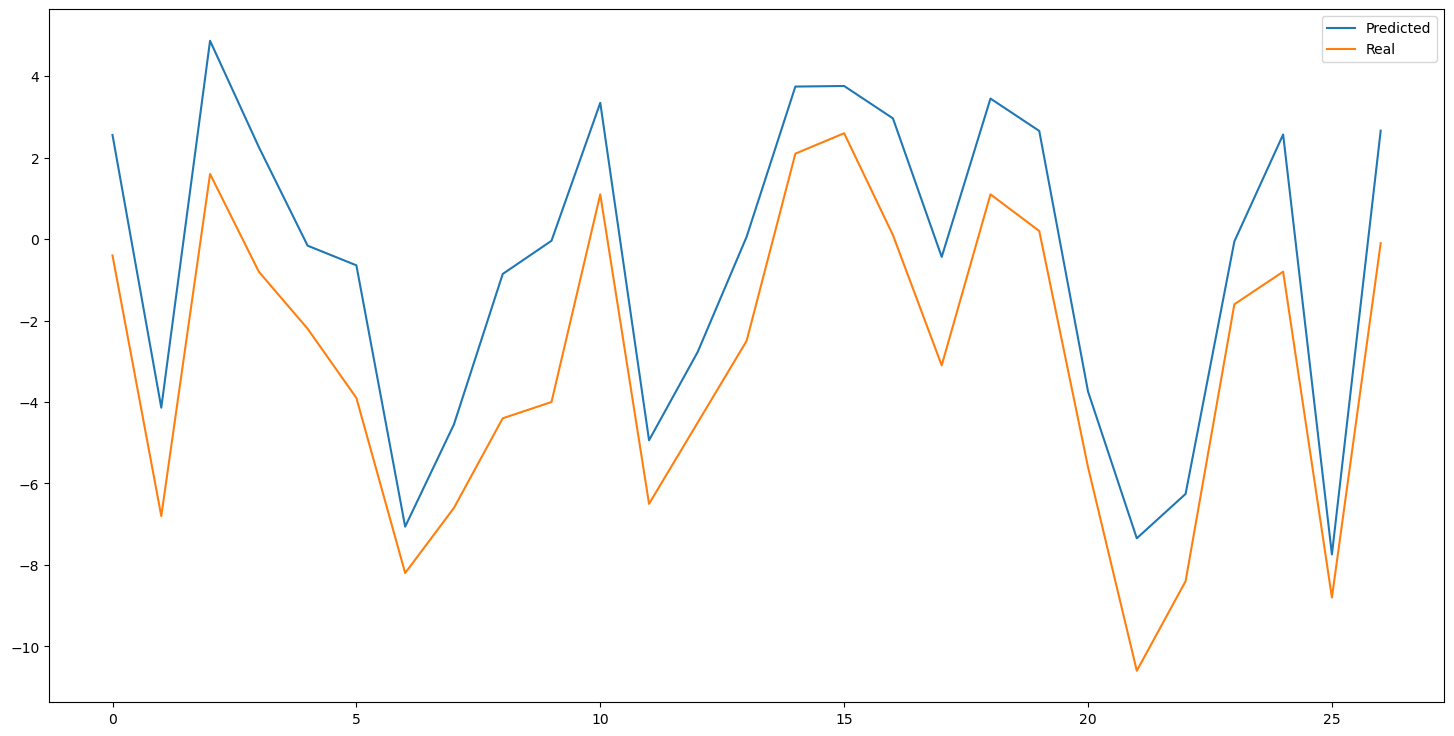

In [90]:
print(R_list)
print(data_1965_1989_temp.shape)
pred = np.einsum("ijk, kmi -> jm", R_list, data_1965_1989_temp[:, :, :-1])
real = data_1965_1989_temp[:, :, -1]
print(pred)
print(real)

plt.figure(figsize=(18, 9))
plt.plot(pred[:, 0], label="Predicted")
plt.plot(real[:, 0], label="Real")
plt.legend()
plt.show()

data_1990_2014 = df_all[(df_all["Year"] >= 1990) & (df_all["Year"] < 2015)]
data_1990_2014_time = data_1990_2014.groupby("Station")
data_1990_2014_temp = np.array(
    data_1990_2014_time["Temperature"]
    .apply(lambda x: np.array(x.values.tolist()))
    .values.tolist()
).reshape(
    len(stations), -1, 12
)
pred_test = np.einsum("ijk, kmi -> jm", R_list, data_1990_2014_temp[:, :, :-1])
real = data_1990_2014_temp[:, :, -1]

plt.figure(figsize=(18, 9))
plt.plot(pred[:, 0], label="Predicted")
plt.plot(real[:, 0], label="Real")
plt.legend()
plt.show()